# Predicting Concentrations of PM<sub>2.5</sub> #

In [1]:
import openaq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from aqtools import aqutils as u

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD

from noaa_sdk import noaa

api = openaq.OpenAQ()

## Version 1

In [2]:
# Parameter setting

date_from = '2021-09-01T00:00:00Z' # Default: PST
date_to = '2022-03-01T00:00:00Z'
city = 'San Francisco-Oakland-Fremont'
location = 'Oakland'
date_retrieval_limit = 4000

In [4]:
# co
pollutant = 'co'
status, resp = api.measurements(city=city,
                                location=location, parameter=pollutant,
                                date_from=date_from,
                                date_to=date_to,
                                limit=date_retrieval_limit)
r = resp['results']
df_co = u.date_pollutant_value(r, pollutant)
df_co.head(3)

,date,co
3600,2021-08-31 17:00:00,0.3
3599,2021-08-31 18:00:00,0.3
3598,2021-08-31 19:00:00,0.3


In [7]:
# no2
pollutant = 'no2'
status, resp = api.measurements(city=city,
                                location=location, parameter=pollutant,
                                date_from=date_from,
                                date_to=date_to,
                                limit=date_retrieval_limit)
r = resp['results']
df_no2 = u.date_pollutant_value(r, pollutant)

df_no2.head(3)

,date,no2
3599,2021-08-31 17:00:00,0.002
3598,2021-08-31 18:00:00,0.003
3597,2021-08-31 19:00:00,0.004


In [10]:
# o3
pollutant = 'o3'
status, resp = api.measurements(city=city,
                                location=location, parameter=pollutant,
                                date_from=date_from,
                                date_to=date_to,
                                limit=date_retrieval_limit)
r = resp['results']
df_o3 = pd.DataFrame(data=r)
df_o3 = u.date_pollutant_value(r, pollutant)

df_o3.head(3)

,date,o3
3600,2021-08-31 17:00:00,0.031
3599,2021-08-31 18:00:00,0.031
3598,2021-08-31 19:00:00,0.030


In [12]:
# pm25
pollutant = 'pm25'
status, resp = api.measurements(city=city,
                                location=location, parameter=pollutant,
                                date_from=date_from,
                                date_to=date_to,
                                limit=date_retrieval_limit)
r = resp['results']
df_pm25 = pd.DataFrame(data=r)
df_pm25 = u.date_pollutant_value(r, pollutant)

df_pm25.head(3)

,date,pm25
3751,2021-08-31 17:00:00,11
3750,2021-08-31 18:00:00,12
3749,2021-08-31 19:00:00,15


In [13]:
# Merge dataframes on 'date' (find the intersection of values based on 'date')
df = df_co.merge(df_no2, how='inner', on='date')
df = df.merge(df_o3, how='inner', on='date')
df = df.merge(df_pm25, how='inner', on='date')
df = df.set_index(['date'])
df

,co,no2,o3,pm25
date,,,,
2021-08-31 17:00:00,0.30,0.002,0.031,11
2021-08-31 18:00:00,0.30,0.003,0.031,12
2021-08-31 19:00:00,0.30,0.004,0.030,15
2021-08-31 20:00:00,0.36,0.006,0.029,14
2021-08-31 21:00:00,0.37,0.006,0.028,12
...,...,...,...,...
2022-02-28 12:00:00,0.47,0.025,0.023,15
2022-02-28 13:00:00,0.46,0.025,0.026,20
2022-02-28 14:00:00,0.38,0.016,0.038,13


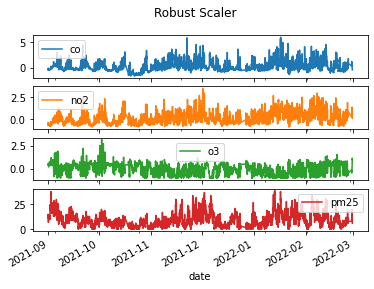

In [14]:
# MinMax Scaling
scaler = RobustScaler()
co_scaled = scaler.fit_transform(df['co'].values.reshape(-1, 1))
df['co'] = co_scaled

scaler = RobustScaler()
co_scaled = scaler.fit_transform(df['no2'].values.reshape(-1, 1))
df['no2'] = co_scaled

scaler = RobustScaler()
co_scaled = scaler.fit_transform(df['o3'].values.reshape(-1, 1))
df['o3'] = co_scaled

df.plot(subplots=True, title='Robust Scaler')
fig = plt.gcf()
fig.savefig("./figures/scaling_ver1.png")
plt.show()

/tmp/ipykernel_11733/490855220.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['co'] = co_diff
/tmp/ipykernel_11733/490855220.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['no2'] = no2_diff
/tmp/ipykernel_11733/490855220.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

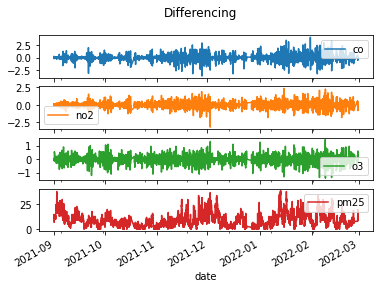

In [15]:
# Make data stationary
# Differencing technique was applied

co_diff = u.differencing(df['co'].values)
no2_diff = u.differencing(df['no2'].values)
o3_diff = u.differencing(df['o3'].values)
# Delete the first row
df = df.iloc[:-1, :]

df['co'] = co_diff
df['no2'] = no2_diff
df['o3'] = o3_diff
df.plot(subplots=True, title='Differencing')
fig = plt.gcf()
fig.savefig("./figures/differencing_ver1.png")
plt.show()

In [16]:
# correlation among features
df_corr = df.corr()
df_corr.to_csv('./tables/correlation_ver1.csv')
df_corr

,co,no2,o3,pm25
co,1.000000,0.673827,-0.623135,-0.118771
no2,0.673827,1.000000,-0.770821,-0.113108
o3,-0.623135,-0.770821,1.000000,0.080400
pm25,-0.118771,-0.113108,0.080400,1.000000


In [17]:
# feature vectors: shape (num of data, window size, num of features)
feature_np = df[['co', 'no2', 'o3']].to_numpy()

# label vactors: shape (num of data,)
label_np = df[['pm25']].to_numpy()
X = []
y = []

# how many timesteps we want to look at --> default 8 (hours)
for i in range(8, len(feature_np)):
    X.append(feature_np[i-8:i, :])
    y.append(label_np[i])

X, y = np.array(X, dtype=np.float64), np.array(y, dtype=np.float64)
X.shape, y.shape

((3517, 8, 3), (3517, 1))

In [18]:
TEST_SIZE = 300

X_train = X[:-TEST_SIZE]
y_train = y[:-TEST_SIZE]
X_test = X[-TEST_SIZE:]
y_test = y[-TEST_SIZE:]


X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3217, 8, 3), (3217, 1), (300, 8, 3), (300, 1))

In [19]:
# Predict pm2.5 using Gated Recurrent Unit

model = Sequential()
model.add(GRU(units=50,
              return_sequences=True,
              input_shape=X_train[0].shape,
              activation='tanh'))
model.add(GRU(units=50, activation='tanh'))
model.add(Dense(units=2))

# Compiling the GRU
model.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7,
                            momentum=0.9, nesterov=False),
              loss='mse')

model.summary()

2022-05-11 14:09:01.380168: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 8, 50)             8250      
                                                                 
 gru_1 (GRU)                 (None, 50)                15300     
                                                                 
 dense (Dense)               (None, 2)                 102       
                                                                 
Total params: 23,652
Trainable params: 23,652
Non-trainable params: 0
_________________________________________________________________


In [20]:
# model training
#early_stop = EarlyStopping(monitor='loss', mode='min', verbose=0, patience=10)
#model.fit(X_train, y_train, epochs=100, batch_size=150, verbose=1, callbacks=[early_stop])

model.fit(X_train, y_train, epochs=100, batch_size=150, verbose=1)

Epoch 1/100
22/22 [==============================] - 3s 15ms/step - loss: 63.9245
Epoch 2/100
22/22 [==============================] - 0s 13ms/step - loss: 48.2013
Epoch 3/100
22/22 [==============================] - 0s 13ms/step - loss: 46.2972
Epoch 4/100
22/22 [==============================] - 0s 14ms/step - loss: 46.3311
Epoch 5/100
22/22 [==============================] - 0s 14ms/step - loss: 46.0769
Epoch 6/100
22/22 [==============================] - 0s 13ms/step - loss: 47.0481
Epoch 7/100
22/22 [==============================] - 0s 14ms/step - loss: 45.9698
Epoch 8/100
22/22 [==============================] - 0s 13ms/step - loss: 45.3761
Epoch 9/100
22/22 [==============================] - 0s 13ms/step - loss: 44.7721
Epoch 10/100
22/22 [==============================] - 0s 14ms/step - loss: 41.0455
Epoch 11/100
22/22 [==============================] - 0s 14ms/step - loss: 40.2695
Epoch 12/100
22/22 [==============================] - 0s 14ms/step - loss: 41.2605
Epoch 13/100


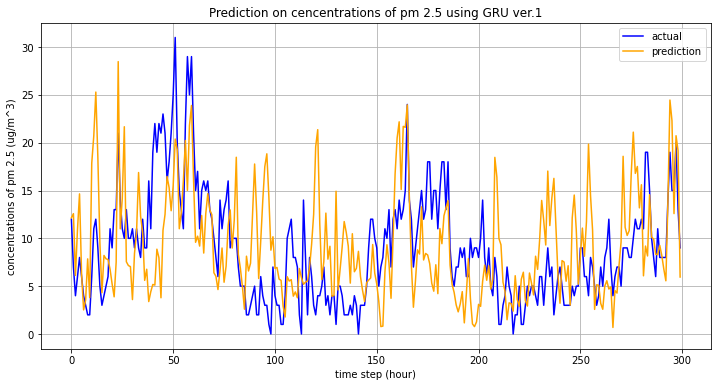

In [21]:
pred = model.predict(X_test)
pred = [p.mean() for p in pred]
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='actual', color='blue')
plt.plot(pred, label='prediction', color='orange')
plt.title('Prediction on cencentrations of pm 2.5 using GRU ver.1')
plt.xlabel('time step (hour)')
plt.ylabel('concentrations of pm 2.5 (ug/m^3)')
plt.grid()
plt.legend(loc='best')
plt.savefig('./figures/prediction_results_ver1.png')
plt.show()

## Version 2
#### Regression with wind speed and relative humidity data

In [22]:
date_from = '2022-05-02T00:00:00Z'
date_to = '2022-05-10T00:00:00Z'
city = 'San Francisco-Oakland-Fremont'
location = 'Oakland'
date_retrieval_limit = 150

date_from_utc = u.pst_to_utc(date_from)
date_to_utc = u.pst_to_utc(date_to)

In [23]:
# co
# From 2022-05-02 To 2022-05-10

pollutant = 'co'
status, resp = api.measurements(city=city,
                                location=location, parameter=pollutant,
                                date_from=date_from,
                                date_to=date_to,
                                limit=date_retrieval_limit)
r = resp['results']
df_co = u.date_pollutant_value(r, pollutant)
df_co.head(3)

,date,co
149,2022-05-02 23:00:00,0.42
148,2022-05-03 00:00:00,0.29
147,2022-05-03 01:00:00,0.29


In [24]:
# no2
pollutant = 'no2'
status, resp = api.measurements(city=city,
                                location=location, parameter=pollutant,
                                date_from=date_from,
                                date_to=date_to,
                                limit=date_retrieval_limit)
r = resp['results']
df_no2 = u.date_pollutant_value(r, pollutant)

df_no2.head(3)

,date,no2
149,2022-05-02 23:00:00,0.013
148,2022-05-03 00:00:00,0.007
147,2022-05-03 01:00:00,0.006


In [25]:
# o3
pollutant = 'o3'
status, resp = api.measurements(city=city,
                                location=location, parameter=pollutant,
                                date_from=date_from,
                                date_to=date_to,
                                limit=date_retrieval_limit)
r = resp['results']
df_o3 = pd.DataFrame(data=r)
df_o3 = u.date_pollutant_value(r, pollutant)

df_o3.head(3)

,date,o3
149,2022-05-02 23:00:00,0.016
148,2022-05-03 00:00:00,0.019
147,2022-05-03 01:00:00,0.019


In [26]:
# pm25
pollutant = 'pm25'
status, resp = api.measurements(city=city,
                                location=location, parameter=pollutant,
                                date_from=date_from,
                                date_to=date_to,
                                limit=date_retrieval_limit)
r = resp['results']
df_pm25 = pd.DataFrame(data=r)
df_pm25 = u.date_pollutant_value(r, pollutant)

df_pm25.head(3)

,date,pm25
149,2022-05-03 04:00:00,8
148,2022-05-03 05:00:00,8
147,2022-05-03 06:00:00,7


In [27]:
n = noaa.NOAA()
res = n.get_observations('94603', 'US', start=date_from_utc, end=date_to_utc, num_of_stations=1)
dates = []
windspeed = []
relativehum = []

for i in res:
    dates.append(u.utc_to_pst(i['timestamp']))
    windspeed.append(i['windSpeed']['value'])
    relativehum.append(i['relativeHumidity']['value'])
df_w = pd.DataFrame()
df_w['date'] = dates
df_w['wind speed'] = windspeed
df_w['relative humidity'] = relativehum
df_w['date'] = pd.to_datetime(df_w['date'])

# fill na with median
df_w[['wind speed', 'relative humidity']] = df_w[['wind speed', 'relative humidity']].fillna(df_w[['wind speed', 'relative humidity']].median())
df_w = df_w.sort_values(by="date")
# df.to_csv('./fillna weather.csv')
df_w.head(3)

,date,wind speed,relative humidity
57,2022-05-04 07:00:00,18.36,74.290523
95,2022-05-04 09:00:00,9.36,72.237266
55,2022-05-04 10:00:00,18.36,62.603058


In [28]:
df = df_co.merge(df_no2, how='inner', on='date')
df = df.merge(df_o3, how='inner', on='date')
df = df.merge(df_w, how='inner', on='date')
df = df.merge(df_pm25, how='inner', on='date')
df = df.set_index(['date'])
df

,co,no2,o3,wind speed,relative humidity,pm25
date,,,,,,
2022-05-04 07:00:00,0.60,0.016,0.008,18.36,74.290523,14
2022-05-04 09:00:00,0.41,0.013,0.024,9.36,72.237266,15
2022-05-04 10:00:00,0.43,0.019,0.027,18.36,62.603058,18
2022-05-04 11:00:00,0.34,0.015,0.034,9.36,45.123994,10
2022-05-04 12:00:00,0.29,0.013,0.038,12.96,39.569368,11
...,...,...,...,...,...,...
2022-05-09 12:00:00,0.22,0.002,0.041,25.92,47.248268,3
2022-05-09 13:00:00,0.22,0.002,0.040,18.36,43.875674,6
2022-05-09 14:00:00,0.21,0.002,0.040,27.72,43.875674,7


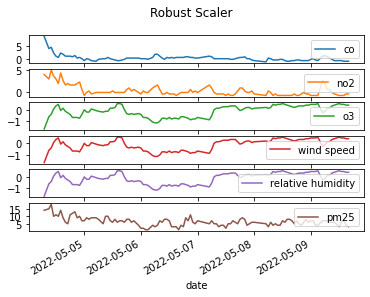

In [29]:
# Scaling
scaler = RobustScaler()
co_scaled = scaler.fit_transform(df['co'].values.reshape(-1, 1))
df['co'] = co_scaled

scaler = RobustScaler()
co_scaled = scaler.fit_transform(df['no2'].values.reshape(-1, 1))
df['no2'] = co_scaled

scaler = RobustScaler()
co_scaled = scaler.fit_transform(df['o3'].values.reshape(-1, 1))
df['o3'] = co_scaled

scaler = RobustScaler()
co_scaled = scaler.fit_transform(df['o3'].values.reshape(-1, 1))
df['wind speed'] = co_scaled

scaler = RobustScaler()
co_scaled = scaler.fit_transform(df['o3'].values.reshape(-1, 1))
df['relative humidity'] = co_scaled

plot = df.plot(subplots=True, title='Robust Scaler')
fig = plt.gcf()
fig.savefig("./figures/scaling_ver2.png")
plt.show()

/tmp/ipykernel_11733/478646036.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['co'] = co_diff
/tmp/ipykernel_11733/478646036.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['no2'] = no2_diff
/tmp/ipykernel_11733/478646036.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

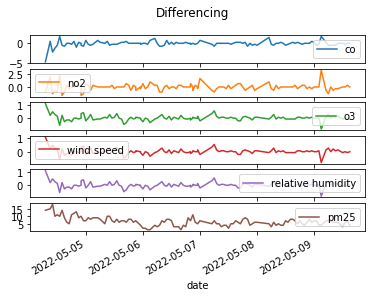

In [30]:
# Make data stationary
# Differencing technique was applied

co_diff = u.differencing(df['co'].values)
no2_diff = u.differencing(df['no2'].values)
o3_diff = u.differencing(df['o3'].values)
ws_diff = u.differencing(df['wind speed'].values)
rh_diff = u.differencing(df['relative humidity'].values)
# Delete the first row
df = df.iloc[:-1, :]

df['co'] = co_diff
df['no2'] = no2_diff
df['o3'] = o3_diff
df['wind speed'] = ws_diff
df['relative humidity'] = rh_diff
plot = df.plot(subplots=True, title='Differencing')
fig = plt.gcf()
fig.savefig("./figures/differencing_ver2.png")
plt.show()

In [31]:
# correlation among features
df_corr = df.corr()
df_corr.to_csv('./tables/correlation_ver2.csv')
df_corr

,co,no2,o3,wind speed,relative humidity,pm25
co,1.000000,0.599696,-0.725872,-0.725872,-0.725872,-0.334219
no2,0.599696,1.000000,-0.687908,-0.687908,-0.687908,-0.187019
o3,-0.725872,-0.687908,1.000000,1.000000,1.000000,0.294662
wind speed,-0.725872,-0.687908,1.000000,1.000000,1.000000,0.294662
relative humidity,-0.725872,-0.687908,1.000000,1.000000,1.000000,0.294662
pm25,-0.334219,-0.187019,0.294662,0.294662,0.294662,1.000000


In [32]:
# feature vectors: shape (num of data, window size, num of features)
feature_np = df[['co', 'no2', 'o3', 'wind speed', 'relative humidity']].to_numpy()

# label vactors: shape (num of data,)
label_np = df[['pm25']].to_numpy()
X = []
y = []

# how many timesteps we want to look at --> default 8 (hours)
for i in range(8, len(feature_np)):
    X.append(feature_np[i-8:i, :])
    y.append(label_np[i])

X, y = np.array(X, dtype=np.float64), np.array(y, dtype=np.float64)
X.shape, y.shape

((113, 8, 5), (113, 1))

In [33]:
TEST_SIZE = 30

X_train = X[:-TEST_SIZE]
y_train = y[:-TEST_SIZE]
X_test = X[-TEST_SIZE:]
y_test = y[-TEST_SIZE:]


X_train.shape, y_train.shape, X_test.shape, y_test.shape

((83, 8, 5), (83, 1), (30, 8, 5), (30, 1))

In [38]:
# Predict pm2.5 using Gated Recurrent Unit

model = Sequential()
model.add(GRU(units=50,
              return_sequences=True,
              input_shape=X_train[0].shape,
              activation='tanh'))
model.add(GRU(units=50, activation='tanh'))
model.add(Dense(units=2))

# Compiling the GRU
model.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7,
                            momentum=0.9, nesterov=False),
              loss='mse')

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 8, 50)             8550      
                                                                 
 gru_5 (GRU)                 (None, 50)                15300     
                                                                 
 dense_2 (Dense)             (None, 2)                 102       
                                                                 
Total params: 23,952
Trainable params: 23,952
Non-trainable params: 0
_________________________________________________________________


In [39]:
# model training
early_stop = EarlyStopping(monitor='loss', mode='min', verbose=0, patience=10)
model.fit(X_train, y_train, epochs=50, batch_size=100, verbose=1, callbacks=[early_stop])


Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 45.2418
Epoch 2/50
1/1 [==============================] - 0s 13ms/step - loss: 40.6291
Epoch 3/50
1/1 [==============================] - 0s 14ms/step - loss: 32.6973
Epoch 4/50
1/1 [==============================] - 0s 13ms/step - loss: 22.4436
Epoch 5/50
1/1 [==============================] - 0s 14ms/step - loss: 12.0291
Epoch 6/50
1/1 [==============================] - 0s 13ms/step - loss: 6.9773
Epoch 7/50
1/1 [==============================] - 0s 14ms/step - loss: 9.6087
Epoch 8/50
1/1 [==============================] - 0s 14ms/step - loss: 13.7595
Epoch 9/50
1/1 [==============================] - 0s 12ms/step - loss: 13.3442
Epoch 10/50
1/1 [==============================] - 0s 12ms/step - loss: 9.5873
Epoch 11/50
1/1 [==============================] - 0s 13ms/step - loss: 7.1876
Epoch 12/50
1/1 [==============================] - 0s 13ms/step - loss: 7.8250
Epoch 13/50
1/1 [==============================] - 0s 11

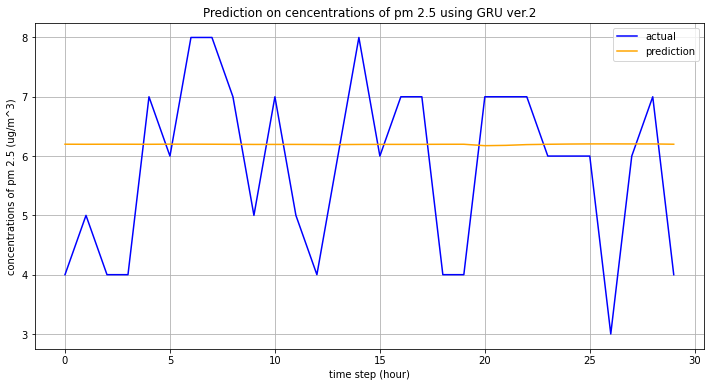

In [40]:
pred = model.predict(X_test)
pred = [p.mean() for p in pred]
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='actual', color='blue')
plt.plot(pred, label='prediction', color='orange')
plt.title('Prediction on concentrations of pm 2.5 using GRU ver.2')
plt.xlabel('time step (hour)')
plt.ylabel('concentrations of pm 2.5 (ug/m^3)')
plt.grid()
plt.legend(loc='best')
plt.savefig('./figures/prediction_results_ver2.png')
plt.show()